
# Learning Rate Finder
### _A method for choosing the Learning Rate for Stochastic Gradient Descent_


## What is the Learning Rate?

$$\theta_{j+1} = \theta_{j} - \alpha  J'(\theta_{j})$$

$$\alpha = \text{learning rate}$$

## Conceptually, how should we set the Learning Rate?

<center>![png](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)</center>
<center>https://www.jeremyjordan.me/nn-learning-rate/</center>

## Complex surface for neural networks

An example for VGG-56:

<center><img src="https://www.cs.umd.edu/~tomg/img/landscapes/noshort.png" width="600px"/></center>

## What effects can we observe?

<center><img src="https://cdn-images-1.medium.com/max/1600/0*uIa_Dz3czXO5iWyI." width="600px"/></center>

# 'Learning Rate Finder' Method

"Cyclical Learning Rates for Training Neural Networks" by Leslie Smith (2015)

Given an initialized network, a defined loss and a training dataset we take the following steps:

1. train one batch at a time (a.k.a. an iteration)
2. start with a very small learning rate (e.g. 0.000001) and slowly increase it every iteration
3. record the training loss and continue until we see the training loss diverge

# 'Learning Rate Finder' Results

<center><img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_finder/finder_plot.png" width="600px"/></center>

# Structure training loop: from Epoch to Iteration

In [1]:
import mxnet as mx

# Set seed for reproducibility
mx.random.seed(42),

class Learner():
    def __init__(self, net, data_loader, ctx):
        """
        net: network (mx.gluon.Block)
        data_loader: training data loader (mx.gluon.data.DataLoader)
        ctx: context (mx.gpu or mx.cpu)
        """
        self.net = net
        self.data_loader = data_loader
        self.ctx = ctx
        # So we don't need to be in `for batch in data_loader` scope
        # and can call for next batch in `iteration`
        self.data_loader_iter = iter(self.data_loader)
        self.net.initialize(mx.init.Xavier(), ctx=self.ctx)
        self.loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
        self.trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .001})
        
    def iteration(self, lr=None, take_step=True):
        """
        lr: learning rate to use for iteration (float)
        take_step: take trainer step to update weights (boolean)
        """
        # Update learning rate if different this iteration
        if lr and (lr != self.trainer.learning_rate):
            self.trainer.set_learning_rate(lr)
        # Get next batch, and move context (e.g. to GPU if set)
        data, label = next(self.data_loader_iter)
        data = data.as_in_context(self.ctx)
        label = label.as_in_context(self.ctx)
        # Standard forward and backward pass
        with mx.autograd.record():
            output = self.net(data)
            loss = self.loss_fn(output, label)
        loss.backward()     
        # Update parameters
        if take_step: self.trainer.step(data.shape[0])  
        # Set and return loss.
        # Although notice this is still an MXNet NDArray to avoid blocking
        self.iteration_loss = mx.nd.mean(loss)
        return self.iteration_loss

    def close(self):
        # Close open iterator and associated workers
        self.data_loader_iter.shutdown()

In [ ]:
import mxnet as mx


class Learner():
    def __init__(self, net, data_loader, ctx):
        """
        net: network (mx.gluon.Block)
        data_loader: training data loader (mx.gluon.data.DataLoader)
        ctx: context (mx.gpu or mx.cpu)
        """
        self.net = net
        self.data_loader = data_loader
        self.ctx = ctx
        # So we don't need to be in `for batch in data_loader` scope
        # and can call for next batch in `iteration`
        self.data_loader_iter = iter(self.data_loader)
        self.net.initialize(mx.init.Xavier(), ctx=self.ctx)
        self.loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
        self.trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .001})
        
    ...

In [ ]:
class Learner():
    
    ...
    
    def iteration(self, lr=None, take_step=True):
        """
        lr: learning rate to use for iteration (float)
        take_step: take trainer step to update weights (boolean)
        """
        # Update learning rate if different this iteration
        if lr and (lr != self.trainer.learning_rate):
            self.trainer.set_learning_rate(lr)
        # Get next batch, and move context (e.g. to GPU if set)
        data, label = next(self.data_loader_iter)
        data = data.as_in_context(self.ctx)
        label = label.as_in_context(self.ctx)
        # Standard forward and backward pass
        with mx.autograd.record():
            output = self.net(data)
            loss = self.loss_fn(output, label)
        loss.backward()     
        # Update parameters
        if take_step: self.trainer.step(data.shape[0])  
        # Set and return loss.
        # Although notice this is still an MXNet NDArray to avoid blocking
        self.iteration_loss = mx.nd.mean(loss)
        return self.iteration_loss
    
    ...  

In [ ]:
class Learner():
    
    ...
    
    def close(self):
        # Close open iterator and associated workers
        self.data_loader_iter.shutdown()

## Continuous DataLoader

In [4]:
from multiprocessing import cpu_count
from mxnet.gluon.data.vision import transforms

transform = transforms.Compose([
    # Switches HWC to CHW, and converts to `float32`
    transforms.ToTensor(),
    # Channel-wise, using pre-computed means and stds 
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

dataset = mx.gluon.data.vision.datasets.CIFAR10(train=True).transform_first(transform)

In [5]:
class ContinuousBatchSampler():
    def __init__(self, sampler, batch_size):
        self._sampler = sampler
        self._batch_size = batch_size

    def __iter__(self):
        batch = []
        while True:
            for i in self._sampler:
                batch.append(i)
                if len(batch) == self._batch_size:
                    yield batch
                    batch = []

In [6]:
sampler = mx.gluon.data.RandomSampler(len(dataset))
batch_sampler = ContinuousBatchSampler(sampler, batch_size=128)
data_loader = mx.gluon.data.DataLoader(dataset, batch_sampler=batch_sampler, num_workers=cpu_count())

# 'Learning Rate Finder' Implementation

In [2]:
from matplotlib import pyplot as plt

class LRFinder():
    def __init__(self, learner):
        """
        learner: able to take single iteration with given learning rate and return loss
           and save and load parameters of the network (Learner)
        """
        self.learner = learner
        
    def find(self, lr_start=1e-6, lr_multiplier=1.1, smoothing=0.3):
        """
        lr_start: learning rate to start search (float)
        lr_multiplier: factor the learning rate is multiplied by at each step of search (float)
        smoothing: amount of smoothing applied to loss for stopping criteria (float)
        """
        # Used to initialize weights; pass data, but don't take step.
        # Would expect for new model with lazy weight initialization
        self.learner.iteration(take_step=False)
        # Used to initialize trainer (if no step has been taken)
        if not self.learner.trainer._kv_initialized:
            self.learner.trainer._init_kvstore()
        # Store params and optimizer state for restore after lr_finder procedure
        # Useful for applying the method partway through training, not just for initialization of lr.
        self.learner.net.save_params("lr_finder.params")
        self.learner.trainer.save_states("lr_finder.state")
        lr = lr_start
        self.results = [] # List of (lr, loss) tuples
        stopping_criteria = LRFinderStoppingCriteria(smoothing)
        while True:
            # Run iteration, and block until loss is calculated.
            loss = self.learner.iteration(lr).asscalar()
            self.results.append((lr, loss))
            if stopping_criteria(loss):
                break
            lr = lr * lr_multiplier
        # Restore params (as finder changed them)
        self.learner.net.load_params("lr_finder.params", ctx=self.learner.ctx)
        self.learner.trainer.load_states("lr_finder.state")
        self.plot()
        
    def plot(self):
        lrs = [e[0] for e in self.results]
        losses = [e[1] for e in self.results]
        plt.figure(figsize=(6,8))
        plt.scatter(lrs, losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.yscale('log')
        axes = plt.gca()
        axes.set_xlim([lrs[0], lrs[-1]])
        y_lower = min(losses) * 0.8
        y_upper = losses[0] * 4
        axes.set_ylim([y_lower, y_upper])
        plt.show()

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [ ]:
from matplotlib import pyplot as plt

class LRFinder():
    def __init__(self, learner):
        """
        learner: able to take single iteration with given learning rate and return loss
           and save and load parameters of the network (Learner)
        """
        self.learner = learner
        
    ...

In [ ]:
class LRFinder():
    
    ...
    
    def find(self, lr_start=1e-6, lr_multiplier=1.1, smoothing=0.3):
        """
        lr_start: learning rate to start search (float)
        lr_multiplier: factor the learning rate is multiplied by at each step of search (float)
        smoothing: amount of smoothing applied to loss for stopping criteria (float)
        """
        # Used to initialize weights; pass data, but don't take step.
        # Would expect for new model with lazy weight initialization
        self.learner.iteration(take_step=False)
        # Used to initialize trainer (if no step has been taken)
        if not self.learner.trainer._kv_initialized:
            self.learner.trainer._init_kvstore()
        # Store params and optimizer state for restore after lr_finder procedure
        # Useful for applying the method partway through training, not just for initialization of lr.
        self.learner.net.save_params("lr_finder.params")
        self.learner.trainer.save_states("lr_finder.state")
        lr = lr_start
        self.results = [] # List of (lr, loss) tuples
        stopping_criteria = LRFinderStoppingCriteria(smoothing)
        while True:
            # Run iteration, and block until loss is calculated.
            loss = self.learner.iteration(lr).asscalar()
            self.results.append((lr, loss))
            if stopping_criteria(loss):
                break
            lr = lr * lr_multiplier
        # Restore params (as finder changed them)
        self.learner.net.load_params("lr_finder.params", ctx=self.learner.ctx)
        self.learner.trainer.load_states("lr_finder.state")
        self.plot()

    ...

In [ ]:
class LRFinder():
    
    ...
       
    def plot(self):
        lrs = [e[0] for e in self.results]
        losses = [e[1] for e in self.results]
        plt.figure(figsize=(6,8))
        plt.scatter(lrs, losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.yscale('log')
        axes = plt.gca()
        axes.set_xlim([lrs[0], lrs[-1]])
        y_lower = min(losses) * 0.8
        y_upper = losses[0] * 4
        axes.set_ylim([y_lower, y_upper])
        plt.show()

## Stopping Criteria

In [7]:
class LRFinderStoppingCriteria():
    def __init__(self, smoothing=0.3, min_iter=20):
        """
        smoothing: applied to running mean which is used for thresholding (float)
        min_iter: minimum number of iterations before early stopping can occur (int)
        """
        self.smoothing = smoothing
        self.min_iter = min_iter
        self.first_loss = None
        self.running_mean = None
        self.counter = 0
        
    def __call__(self, loss):
        """
        loss: from single iteration (float)
        """
        self.counter += 1
        if self.first_loss is None:
            self.first_loss = loss
        if self.running_mean is None:
            self.running_mean = loss
        else:
            self.running_mean = ((1 - self.smoothing) * loss) + (self.smoothing * self.running_mean)
        return (self.running_mean > self.first_loss * 2) and (self.counter >= self.min_iter)

# 'Learning Rate Finder' Usage

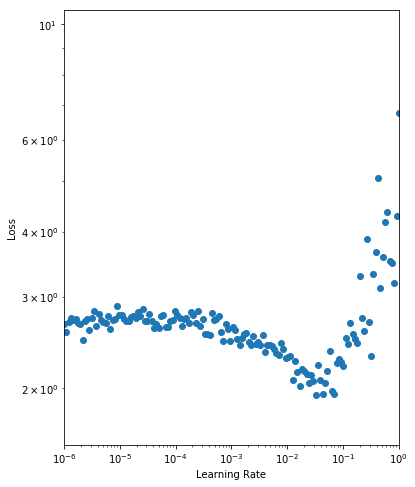

In [8]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, ctx=ctx)
lr_finder = LRFinder(learner)
lr_finder.find(lr_start=1e-6)

In [9]:
learner.net.save_params("net.params")
lr = 0.05

for iter_idx in range(500):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss.asscalar()))
print("Final Loss: {:.5g}".format(learner.iteration_loss.asscalar()))

Iteration: 0, Loss: 2.7886
Iteration: 100, Loss: 1.6369
Iteration: 200, Loss: 1.421
Iteration: 300, Loss: 1.3718
Iteration: 400, Loss: 1.2081
Final Loss: 1.0667


In [10]:
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, ctx=ctx)
learner.net.load_params("net.params", ctx=ctx)
lr = 0.5

for iter_idx in range(500):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss.asscalar()))
print("Final Loss: {:.5g}".format(learner.iteration_loss.asscalar()))

Iteration: 0, Loss: 2.8218
Iteration: 100, Loss: 1.8237
Iteration: 200, Loss: 1.6513
Iteration: 300, Loss: 1.3373
Iteration: 400, Loss: 1.3635
Final Loss: 1.1876


In [11]:
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, ctx=ctx)
learner.net.load_params("net.params", ctx=ctx)
lr = 0.005

for iter_idx in range(500):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss.asscalar()))
print("Final Loss: {:.5g}".format(learner.iteration_loss.asscalar()))

Iteration: 0, Loss: 2.7218
Iteration: 100, Loss: 1.8424
Iteration: 200, Loss: 1.7882
Iteration: 300, Loss: 1.4884
Iteration: 400, Loss: 1.2297
Final Loss: 1.3336
